   time     U_avg       P_avg   phi_avg
0   100  0.986019    0.618256  0.000003
1   200  1.432631  106.296896  0.000002
2   300  0.968507   10.443722  0.000003
3   400  1.076884   10.381788  0.000002
4   500  2.174780   29.761303  0.000004
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   time     10 non-null     int64  
 1   U_avg    10 non-null     float64
 2   P_avg    10 non-null     float64
 3   phi_avg  10 non-null     float64
dtypes: float64(3), int64(1)
memory usage: 452.0 bytes
None
              time      U_avg       P_avg       phi_avg
count    10.000000  10.000000   10.000000  1.000000e+01
mean    550.000000   1.649094   33.030798  2.612169e-06
std     302.765035   1.399599   59.030940  6.195124e-07
min     100.000000   0.968507   -3.447362  1.921074e-06
25%     325.000000   0.990456    0.720389  2.146438e-06
50%     550.000000   1.049589    6.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Linear Regression --> RMSE:  129.6523, R2: -14.2120
RandomForest --> RMSE:  128.4419, R2: -13.9293
XGBoost --> RMSE:  118.6500, R2: -11.7398


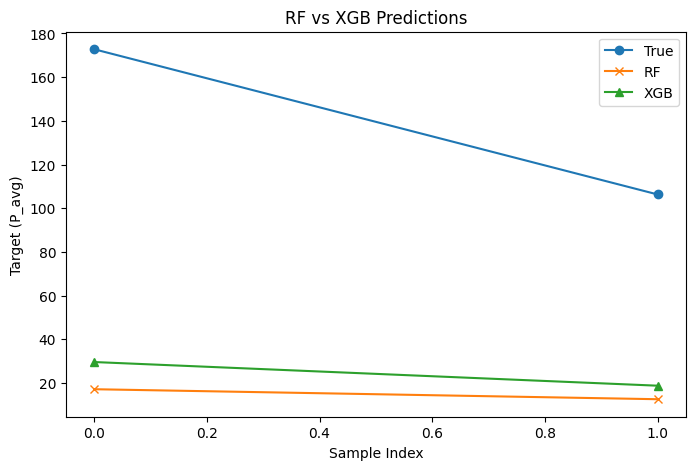

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# Load averaged data
avg_df = pd.read_csv("CoolingChannel_U1.2_T350_avg.csv")


print(avg_df.head())

# INFO about the data
# info() tells number of rows, columns, and if there are missing values
# describe() gives statistical summary: mean, std, min, max -- helps spot anything unusual.
print(avg_df.info())
print(avg_df.describe())

# Replace NaN with 0
avg_df.fillna(0, inplace=True)

# We can drop rows with NaN if we prefer
# avg_df.dropna(inplace=True)

# Features(X): U_avg, p_avg, phi_avg
# Target(y): let us pick p_avg first, just to test pipeline.(later we'll switch to dp, T_out, HT,etc.)

# Define features & Target
X = avg_df[['U_avg', 'P_avg', 'phi_avg']]
y = avg_df['P_avg']

# Split into training(80%) and testing(20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale the features --> ensures all feature(velocity, pressure, flux) are comparable in magnitude.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ================================================================ #
# Train Baseline ML Model
# (we will train for Linear R egression, RandomForest, XGBoost)

# 1. Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test_scaled)

# 2. Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

# 3. XGBoost
xgb = XGBRegressor(n_estimators=200, learning_rate=0.05, random_state=42)
xgb.fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)

# Evaluate the models
def rmse_manual(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))
def r2_manual(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res/ss_tot

# Metrics for all models
models = {
    'Linear Regression' : y_pred_lr,
    'RandomForest'      : y_pred_rf,
    'XGBoost'           : y_pred_xgb
}

for model_name,y_pred in models.items():
  rmse_val = rmse_manual(y_test.values, y_pred)
  r2_val = r2_manual(y_test.values, y_pred)
  print(f"{model_name} --> RMSE: {rmse_val: .4f}, R2: {r2_val: .4f}")


# Let us compare predictions visually
plt.figure(figsize=(8,5))
plt.plot(y_test.values, label='True', marker='o')
plt.plot(y_pred_rf, label='RF', marker='x')
plt.plot(y_pred_xgb, label='XGB', marker='^')
plt.title('RF vs XGB Predictions')
plt.xlabel('Sample Index')
plt.ylabel('Target (P_avg)')
plt.legend()
plt.show()

# What we notice: RF = safer for small CFD datasets
#                 XGB = more powerful,  ut requires more cases and tuning to outperform RF.

